#### Taller
#### Procesamiento Distribuido en la Nube
#### Laura Espinosa - Carlos Jaramillo
Configuracion inicial antes de correr Spark

En un terminal, de SageMaker, se debe correr los siguientes comandos para garantizar que se tiene la configuracion adecuada de librerias


In [1]:
import os
os.environ["SPARK_VERSION"] = '3.3'
os.environ["JAVA_HOME"] = '/usr/lib/jvm/java-11-openjdk-amd64/'

**Instalacion de Librerias**

In [2]:
!pip install pydeequ==1.2.0
!pip install pyspark
!pip install sagemaker_pyspark
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=6ef8f8d3b538dc8fcc89ab01383dd667f46f98c9dbb4f7859b71f19784859880
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 MB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 10.8 MB/s eta 0:00:00
  Created wheel for sagemaker_pyspark: filename=sagemaker_pyspark-1.4.5-py3-none-any.whl size=181610593 sha256=fedda2af44ae2db0657bdeb35dcbddfdbdb255b63ad30a31e1076da4ed6cf99d
  Stored in directory: /root/.cache/pip/wheels/ea/cb/32/140bffbc4ad8465e99b41cd8

**Uso de Librerias**

In [3]:
import pyspark
import sagemaker_pyspark
import pydeequ

In [143]:
from pyspark.sql import SparkSession, Row, DataFrame
import pandas as pd
import sagemaker_pyspark

from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.functions import col, sum as spark_sum

import pydeequ
from pydeequ.repository import *
from pydeequ.analyzers import *
from pydeequ.verification import *
from pydeequ.anomaly_detection import *
from pydeequ.analyzers import *

from pydeequ.profiles import *

import matplotlib.pyplot as plt
import seaborn as sns
import folium

**Creacion de la sesion de Spark**

Utilizando las configuraciones de paquete maven

In [5]:
classpath = ":".join(sagemaker_pyspark.classpath_jars())

spark = (SparkSession
    .builder
    .config("spark.driver.extraClassPath", classpath)
    .config("spark.jars.packages", pydeequ.deequ_maven_coord)
    .config("spark.jars.excludes", pydeequ.f2j_maven_coord)
    .getOrCreate())

In [6]:
# Programmatic way to define a schema
tesla_schema = StructType([StructField('VIN', StringType(), True),
 StructField('County', StringType(), True),
 StructField('City', StringType(), True),#IntegerType
 StructField('State', StringType(), True),
 StructField('Postal_Code', IntegerType(), True),
 StructField('Model_Year', IntegerType(), True),
 StructField('Make', StringType(), True),
 StructField('Model', StringType(), True),
 StructField('Electric_Vehicle_Type', StringType(), True),
 StructField('CAFV', StringType(), True),
 StructField('Electric_Range', IntegerType(), True),
 StructField('Base_MSRP', IntegerType(), True),
 StructField('Legislative_District', IntegerType(), True),
 StructField('DOL_Vehicle_ID', IntegerType(), True),
 StructField('Vehicle_Location', StringType(), True),
 StructField('Electric_Utility', StringType(), True),
 StructField('2020_Census_Tract', LongType(), True)])

In [8]:
#csv_url = "https://raw.githubusercontent.com/carlosjara/MCD_PDN/main/Clase_3_StepFunction/data/Electric_Vehicle_Population_Data.csv"
#falla al traerlo de git, cargar "manualmente"
# df = spark.read.csv("data/Electric_Vehicle_Population_Data.csv", header=True,schema=tesla_schema)
df = spark.read.csv("Electric_Vehicle_Population_Data.csv", header=True,schema=tesla_schema)

In [9]:
print(df.printSchema())

root
 |-- VIN: string (nullable = true)
 |-- County: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Postal_Code: integer (nullable = true)
 |-- Model_Year: integer (nullable = true)
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Electric_Vehicle_Type: string (nullable = true)
 |-- CAFV: string (nullable = true)
 |-- Electric_Range: integer (nullable = true)
 |-- Base_MSRP: integer (nullable = true)
 |-- Legislative_District: integer (nullable = true)
 |-- DOL_Vehicle_ID: integer (nullable = true)
 |-- Vehicle_Location: string (nullable = true)
 |-- Electric_Utility: string (nullable = true)
 |-- 2020_Census_Tract: long (nullable = true)

None


In [15]:
display(df.head(5))

[Row(VIN='5YJ3E1EB0J', County='Thurston', City='Olympia', State='WA', Postal_Code=98512, Model_Year=2018, Make='TESLA', Model='MODEL 3', Electric_Vehicle_Type='Battery Electric Vehicle (BEV)', CAFV='Clean Alternative Fuel Vehicle Eligible', Electric_Range=215, Base_MSRP=0, Legislative_District=35, DOL_Vehicle_ID=104823078, Vehicle_Location='POINT (-122.957046 46.991391)', Electric_Utility='PUGET SOUND ENERGY INC', 2020_Census_Tract=53067012730),
 Row(VIN='WA1AAAGE9M', County='Kitsap', City='Port Orchard', State='WA', Postal_Code=98367, Model_Year=2021, Make='AUDI', Model='E-TRON', Electric_Vehicle_Type='Battery Electric Vehicle (BEV)', CAFV='Clean Alternative Fuel Vehicle Eligible', Electric_Range=222, Base_MSRP=0, Legislative_District=35, DOL_Vehicle_ID=156660507, Vehicle_Location='POINT (-122.6530052 47.4739066)', Electric_Utility='PUGET SOUND ENERGY INC', 2020_Census_Tract=53035092901),
 Row(VIN='5YJ3E1EA2J', County='Yakima', City='Yakima', State='WA', Postal_Code=98902, Model_Year=

In [11]:
# Contar nulos por columna
df.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+---+------+----+-----+-----------+----------+----+-----+---------------------+----+--------------+---------+--------------------+--------------+----------------+----------------+-----------------+
|VIN|County|City|State|Postal_Code|Model_Year|Make|Model|Electric_Vehicle_Type|CAFV|Electric_Range|Base_MSRP|Legislative_District|DOL_Vehicle_ID|Vehicle_Location|Electric_Utility|2020_Census_Tract|
+---+------+----+-----+-----------+----------+----+-----+---------------------+----+--------------+---------+--------------------+--------------+----------------+----------------+-----------------+
|  0|     4|   4|    0|          4|         0|   0|    0|                    0|   0|             0|        0|                 442|             0|               8|               4|                4|
+---+------+----+-----+-----------+----------+----+-----+---------------------+----+--------------+---------+--------------------+--------------+----------------+----------------+-----------------+



Como se puede notar había presencia de valores faltantes para las columnas Country, City, Postal_Code, Legislative_District, Vehicle_Location, Electric_Utility y 200_Census_Tract. La columna con la mayor cantidad de valores faltantes era Legislative_District con un porcentaje del 0.22%. A pesar de contar con estos valores nulos se puede tomar la decisión de eliminarlos ya que no afectarían en gran magnitud la eliminación de estos registros.

In [12]:
# Contar duplicados
df.select("*").groupBy(df.columns).count().filter("count > 1").show()

+---+------+----+-----+-----------+----------+----+-----+---------------------+----+--------------+---------+--------------------+--------------+----------------+----------------+-----------------+-----+
|VIN|County|City|State|Postal_Code|Model_Year|Make|Model|Electric_Vehicle_Type|CAFV|Electric_Range|Base_MSRP|Legislative_District|DOL_Vehicle_ID|Vehicle_Location|Electric_Utility|2020_Census_Tract|count|
+---+------+----+-----+-----------+----------+----+-----+---------------------+----+--------------+---------+--------------------+--------------+----------------+----------------+-----------------+-----+
+---+------+----+-----+-----------+----------+----+-----+---------------------+----+--------------+---------+--------------------+--------------+----------------+----------------+-----------------+-----+



No se encontró presencia de valores duplicados.

In [13]:
df.describe().show()

+-------+----------+------+--------+------+-----------------+------------------+--------------------+------------------+---------------------+--------------------+-----------------+-----------------+--------------------+-------------------+--------------------+--------------------+--------------------+
|summary|       VIN|County|    City| State|      Postal_Code|        Model_Year|                Make|             Model|Electric_Vehicle_Type|                CAFV|   Electric_Range|        Base_MSRP|Legislative_District|     DOL_Vehicle_ID|    Vehicle_Location|    Electric_Utility|   2020_Census_Tract|
+-------+----------+------+--------+------+-----------------+------------------+--------------------+------------------+---------------------+--------------------+-----------------+-----------------+--------------------+-------------------+--------------------+--------------------+--------------------+
|  count|    200048|200044|  200044|200048|           200044|            200048|        

De acuerdo con la tabla anterior podemos ver el Rango eléctrico de los vehículos en la base de datos tiene una media de 53.48, una desviación estándar de 88.78, un mínimo de 0 y un máximo de 337. Las demás variables se toman como categóricas.

In [16]:
df.groupBy("Make").count().orderBy("count", ascending=False).show()

+-------------+-----+
|         Make|count|
+-------------+-----+
|        TESLA|88083|
|    CHEVROLET|14806|
|       NISSAN|14416|
|         FORD|10547|
|          KIA| 8763|
|          BMW| 8295|
|       TOYOTA| 7681|
|   VOLKSWAGEN| 5565|
|      HYUNDAI| 5476|
|         JEEP| 5288|
|       RIVIAN| 5213|
|        VOLVO| 4707|
|         AUDI| 4074|
|     CHRYSLER| 3620|
|MERCEDES-BENZ| 1879|
|      PORSCHE| 1220|
|       SUBARU| 1167|
|     POLESTAR| 1112|
|         MINI| 1011|
|   MITSUBISHI| 1007|
+-------------+-----+
only showing top 20 rows



En la tabla anterior se puede detallar la cantidad de vehículos eléctricos que había en la base de datos discriminados por marca fabricante. En total TESLA es la que mayor población de vehículos eléctricos tiene con modelos desde 1997 y hasta 2025, esto corresponde al 44% de los datos. Una de las marcas fabricantes con menos vehículos es MITSUBISHI con un porcentaje del 0.5%.

In [17]:
df.groupBy("CAFV").count().orderBy("count", ascending=False).show()

+--------------------+------+
|                CAFV| count|
+--------------------+------+
|Eligibility unkno...|109401|
|Clean Alternative...| 69622|
|Not eligible due ...| 21025|
+--------------------+------+



Se puede detallar que la tabla anterior hace referencia a la elegibilidad de los vehículos para ser considerados vehículos de combustible alternativo limpio en función de su rango de batería. Aproximadamente la elegibilidad del 55% de los vehículos en la base de datos es desconocida porque no se ha investigado o verificado el rango de la batería del vehículo. Ahora, el 35% son vehículos elegibles para ser clasificados como vehículos de combustible alternativo limpio. Y, por último, el 11% de estos vehículos no son elegibles para ser clasificados como vehículos de combustible alternativo limpio porque su rango de batería es bajo.

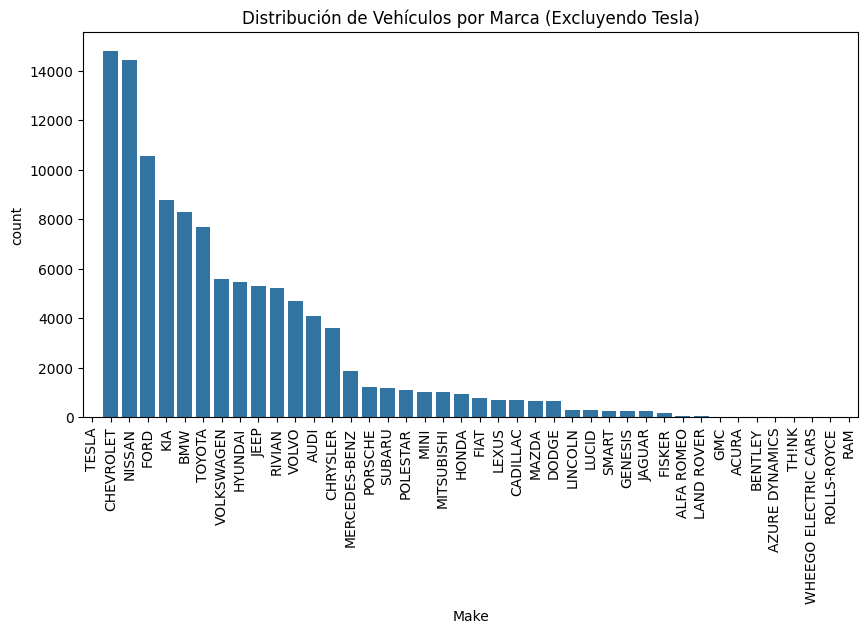

In [19]:
# Convertir a pandas Para graficar
pandas_df = df.toPandas()

plt.figure(figsize=(10,5))
# Filtrar el DataFrame y crear el gráfico de barras en una línea
sns.countplot(data=pandas_df[pandas_df['Make'] != 'TESLA'], x='Make', order=pandas_df['Make'].value_counts().index)

plt.xticks(rotation=90)
plt.title('Distribución de Vehículos por Marca (Excluyendo Tesla)')
plt.show()

Como se puede notar en la anterior grafica (sin contar Tesla, ya que ella ocupa el 44% de los datos), se puede ver que las marcas con una fuerte participación en el mercado de vehículos eléctricos son CHEVROLET y NISSAN con un porcentaje en conjunto del 15%. Además, se puede ver que las marcas GMC, ACURA, BENTLEY, AZURE DYNAMICS THINKS, WHHEGO ELECTRIC CARS, ROLLS-RIYCE y RAM tienen una menor participación en el mercado.

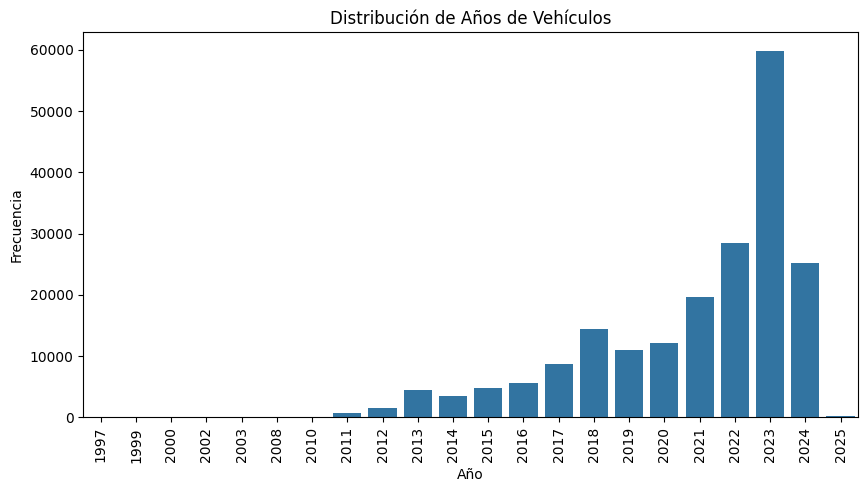

In [20]:
# Contar la frecuencia de cada año
year_counts = pandas_df['Model_Year'].value_counts().sort_index()
plt.figure(figsize=(10,5))

# Crear el gráfico de barras
sns.barplot(x=year_counts.index, y=year_counts.values)

plt.title('Distribución de Años de Vehículos')
plt.xlabel('Año')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)
plt.show()

La gráfica anterior muestra los años con mayor distribución de vehículos eléctricos. Este comportamiento es comprensible, ya que los avances tecnológicos recientes han facilitado el desarrollo de fuentes de energía más limpias y sostenibles en comparación con años anteriores. Es importante destacar que se observa un pico significativo en los vehículos modelo 2023, que representa aproximadamente el 30% del total.

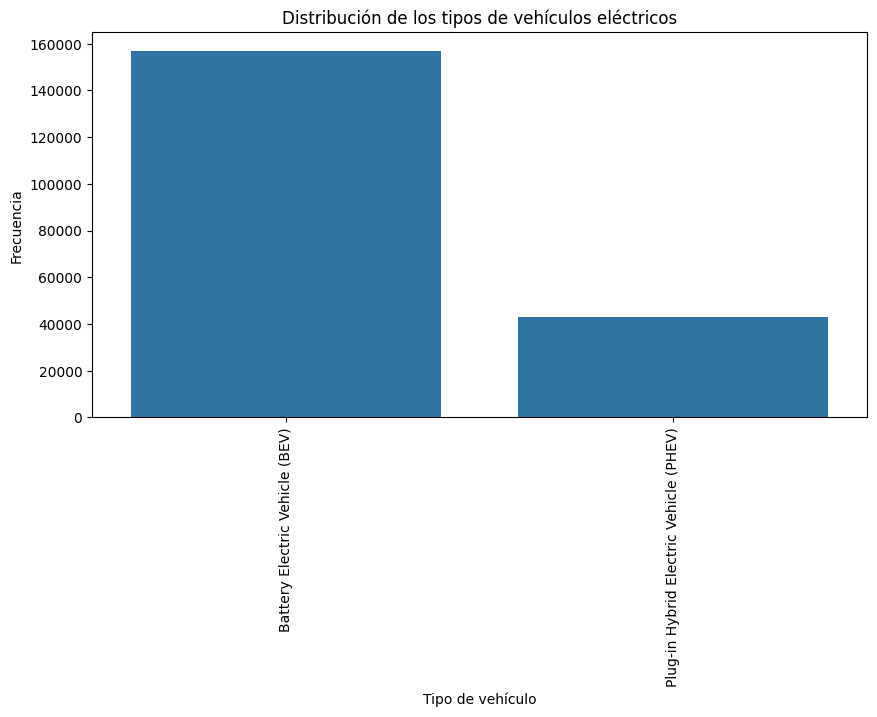

In [23]:
# Contar la frecuencia de cada tipo de vehiculo electrico
year_counts = pandas_df['Electric_Vehicle_Type'].value_counts().sort_index()
plt.figure(figsize=(10,5))

# Crear el gráfico de barras
sns.barplot(x=year_counts.index, y=year_counts.values)

plt.title('Distribución de los tipos de vehículos eléctricos')
plt.xlabel('Tipo de vehículo')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)
plt.show()

En la grafica anterior se puede notar que la mayoría de los vehículos en la base de datos son vehículos eléctricos de batería esto corresponde al 75% de los datos, el restante corresponde a vehículos eléctricos híbridos enchufables.

<ipython-input-144-b738b6b18f30>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pandas_df.loc[pandas_df['Electric_Vehicle_Type'] == "Battery Electric Vehicle (BEV)", var_num], shade=True, color='purple', label='Battery Electric Vehicle')
<ipython-input-144-b738b6b18f30>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pandas_df.loc[pandas_df['Electric_Vehicle_Type'] == "Plug-in Hybrid Electric Vehicle (PHEV)", var_num], shade=True, color='red', label='Plug-in Hybrid Electric Vehicle')


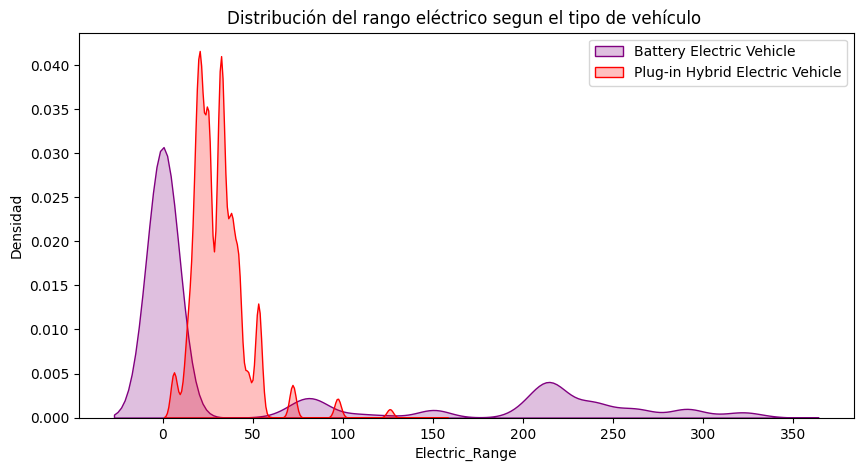

In [144]:
# Configuramos el tamaño de la figura
plt.figure(figsize=(10, 5))

var_num = 'Electric_Range'
sns.kdeplot(pandas_df.loc[pandas_df['Electric_Vehicle_Type'] == "Battery Electric Vehicle (BEV)", var_num], shade=True, color='purple', label='Battery Electric Vehicle')
sns.kdeplot(pandas_df.loc[pandas_df['Electric_Vehicle_Type'] == "Plug-in Hybrid Electric Vehicle (PHEV)", var_num], shade=True, color='red', label='Plug-in Hybrid Electric Vehicle')
plt.title(f'Distribución del rango eléctrico segun el tipo de vehículo ')
plt.xlabel(var_num)
plt.ylabel('Densidad')
plt.legend()
plt.show()

El gráfico anterior muestra las distribuciones del rango eléctrico de los vehículos en la base de datos según el tipo de vehículo, ya sean vehículos eléctricos de batería o vehículos eléctricos híbridos enchufables.

In [80]:
# Agregar latitud y longitud

df = df.withColumn('loc_longitude', regexp_extract('Vehicle_Location', r'POINT \(([-\d.]+) ([-\d.]+)\)', 1)) \
       .withColumn('loc_latitude', regexp_extract('Vehicle_Location', r'POINT \(([-\d.]+) ([-\d.]+)\)', 2))

# Mostrar el DataFrame original con las nuevas columnas
df.show(truncate=False)

+----------+---------+------------+-----+-----------+----------+---------+-------+--------------------------------------+------------------------------------------------------------+--------------+---------+--------------------+--------------+-------------------------------+--------------------------------------------+-----------------+-------------+------------+
|VIN       |County   |City        |State|Postal_Code|Model_Year|Make     |Model  |Electric_Vehicle_Type                 |CAFV                                                        |Electric_Range|Base_MSRP|Legislative_District|DOL_Vehicle_ID|Vehicle_Location               |Electric_Utility                            |2020_Census_Tract|loc_longitude|loc_latitude|
+----------+---------+------------+-----+-----------+----------+---------+-------+--------------------------------------+------------------------------------------------------------+--------------+---------+--------------------+--------------+-------------------------

In [151]:
df_2013 = df.filter(df["Model_Year"] == 2023)
df_filtered = df_2013.na.drop(subset=["loc_latitude", "loc_longitude"]).limit(100)

# Convertir el DataFrame de PySpark a Pandas
df_pandas = df_filtered.select("loc_latitude", "loc_longitude").toPandas()

# Crear un mapa centrado en una ubicación inicial (puedes ajustarla según tu necesidad)
mapa = folium.Map(location=[47.839957, -122.206146], zoom_start=10)

# Recorrer las filas del DataFrame y agregar marcadores
for i, row in df_pandas.iterrows():
    lat = row['loc_latitude']
    lon = row['loc_longitude']
    folium.Marker([lat, lon], popup=f'Lat: {lat}, Lon: {lon}').add_to(mapa)

# Guardar el mapa en un archivo HTML
mapa.save('mapa_marcadores.html')

# Mostrar el mapa interactivo en el notebook (si estás en un entorno que lo soporte)
display(mapa)

El gráfico anterior es una muestra de 100 ubicaciones de los vehículos eléctricos de modelo año 2013.

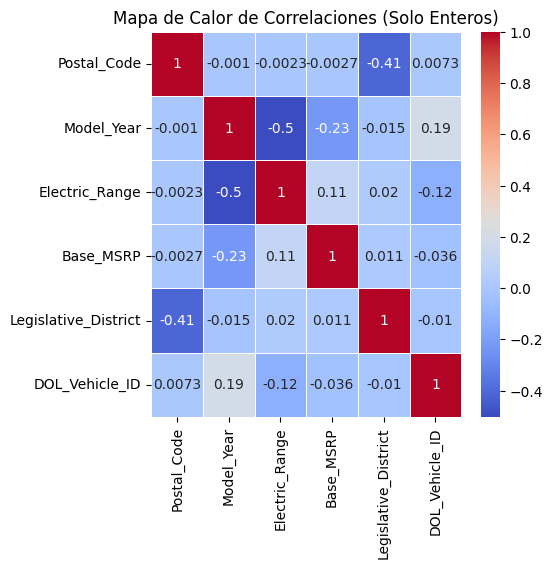

In [24]:
# Seleccionar solo columnas de tipo entero
integer_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, IntegerType)]

# Seleccionar solo esas columnas
df_integers = df.select(integer_columns)
# Convertir a pandas
pandas_df_integers = df_integers.toPandas()


plt.figure(figsize = (5,5))

# Calcular la matriz de correlación
corr_matrix = pandas_df_integers.corr()

# Crear el mapa de calor
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Mostrar el gráfico
plt.title('Mapa de Calor de Correlaciones (Solo Enteros)')
plt.show()

En el anterior grafico se puede detallar las correlaciones entre las variables numéricas, una de las correlaciones altas moderadas es entre el modelo del vehículo y el rango eléctrico esta relación está influenciada por varios factores tecnológicos y de diseño que mejoran con el tiempo. A medida que los fabricantes lanzan nuevos modelos, suelen integrar avances que impactan directamente en el rendimiento de la batería y, por lo tanto, en la autonomía del vehículo.

Otra relación alta moderada se da entre el distrito legislativo y el código postal en el contexto de los vehículos eléctricos puede ser relevante en términos de políticas públicas, incentivos fiscales y regulaciones locales que afectan la adopción y distribución de estos vehículos. Cada distrito legislativo puede tener diferentes normativas o incentivos para promover el uso de vehículos eléctricos, lo que podría influir en la cantidad y tipo de vehículos registrados en ciertos códigos postales.

#### Usando deequ para calidad de datos

In [25]:
analysisResult = AnalysisRunner(spark) \
                    .onData(df) \
                    .addAnalyzer(Size()) \
                    .addAnalyzer(Completeness("Electric_Range")) \
                    .addAnalyzer(Completeness("DOL_Vehicle_ID")) \
                    .addAnalyzer(Distinctness("Electric_Range")) \
                    .addAnalyzer(Mean("Base_MSRP")) \
                    .addAnalyzer(CountDistinct("Electric_Vehicle_Type")) \
                    .addAnalyzer(MaxLength("Electric_Vehicle_Type")) \
                    .addAnalyzer(Minimum("DOL_Vehicle_ID")) \
                    .addAnalyzer(Maximum("DOL_Vehicle_ID")) \
                    .run()

analysisResult_df = AnalyzerContext.successMetricsAsDataFrame(spark, analysisResult)
analysisResult_df.show()

+-------+--------------------+-------------+--------------------+
| entity|            instance|         name|               value|
+-------+--------------------+-------------+--------------------+
| Column|      Electric_Range| Distinctness|5.198752299448132E-4|
| Column|           Base_MSRP|         Mean|   947.5519125409902|
| Column|Electric_Vehicle_...|    MaxLength|                38.0|
|Dataset|                   *|         Size|            200048.0|
| Column|Electric_Vehicle_...|CountDistinct|                 2.0|
| Column|      DOL_Vehicle_ID| Completeness|                 1.0|
| Column|      DOL_Vehicle_ID|      Minimum|              4385.0|
| Column|      DOL_Vehicle_ID|      Maximum|        4.79254772E8|
| Column|      Electric_Range| Completeness|                 1.0|
+-------+--------------------+-------------+--------------------+



/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


Como se puede observar en los resultados anteriores, por ejemplo, para la variable Electric_Range, este valor podría indicar la proporción de registros en los que aparece un valor específico dentro de la variable, es decir, un valor aparece en aproximadamente el 0.0519% de los registros.

Para Base_MSRP nos indica que el precio de Venta Sugerido por el Fabricante promeido es de 947.55.

El tipo de vehículo eléctrico Plug-in Hybrid Electric Vehicle (PHEV) es el que mas caracteres tenia.

El total de vehículos eléctricos en la base de datos son 200048.

El total de valores distintos en tipos de vehículos es 2.

La variable DOL Vehicle ID con un valor de 1 nos indica que todos los registros o campos necesarios están presentes y tienen valores no nulos o no vacíos. Esto es importante ya que se garantiza la calidad y fiabilidad de los datos antes de utilizarlos en análisis, informes o modelos. Su valor mínimo es de 4385 y su valor máximo es de 4.79E8.  COMPLETAR.

Para la variable Electric_rangue también tenemos un valor de 1 lo que nos indica que todos los registros o campos necesarios están presentes y tienen valores no nulos o no vacíos.

#### Profiling

In [26]:
result = ColumnProfilerRunner(spark) \
            .onData(df) \
            .run()

In [27]:
for col, profile in result.profiles.items():
    print(f'Column \'{col}\'')
    print('\t',f'completeness: {profile.completeness}')
    print('\t',f'approximate number of distinct values: {profile.approximateNumDistinctValues}')
    print('\t',f'datatype: {profile.dataType}')

Column 'CAFV'
	 completeness: 1.0
	 approximate number of distinct values: 3
	 datatype: String
Column 'VIN'
	 completeness: 1.0
	 approximate number of distinct values: 12399
	 datatype: String
Column 'Make'
	 completeness: 1.0
	 approximate number of distinct values: 38
	 datatype: String
Column 'Vehicle_Location'
	 completeness: 0.9999600095976966
	 approximate number of distinct values: 953
	 datatype: String
Column 'Postal_Code'
	 completeness: 0.9999800047988483
	 approximate number of distinct values: 936
	 datatype: Integral
Column 'Electric_Utility'
	 completeness: 0.9999800047988483
	 approximate number of distinct values: 80
	 datatype: String
Column 'Legislative_District'
	 completeness: 0.9977905302727346
	 approximate number of distinct values: 49
	 datatype: Integral
Column 'Model'
	 completeness: 1.0
	 approximate number of distinct values: 146
	 datatype: String
Column 'Electric_Range'
	 completeness: 1.0
	 approximate number of distinct values: 108
	 datatype: Integra

En el resultado anterior se puede detallar las variables en las cuales sus registros o campos necesarios están presentes y tienen valores no nulos o no vacíos, son aquellas con valor 1, para las otras quiere decir que hay presencia de valores faltantes y son columnas que tienen su calidad comprometida. También se puede destacaran la cantidad de valores distintos en cada una de ellas, además del tipo de dato.

In [28]:
totalNumber_profile = result.profiles['Electric_Range']

print(f'Statistics of \'Electric_Range\':')
print('\t',f"minimum: {totalNumber_profile.minimum}")
print('\t',f"maximum: {totalNumber_profile.maximum}")
print('\t',f"mean: {totalNumber_profile.mean}")
print('\t',f"standard deviation: {totalNumber_profile.stdDev}")

Statistics of 'Electric_Range':
	 minimum: 0.0
	 maximum: 337.0
	 mean: 53.48527853315204
	 standard deviation: 88.78607875652003


In [29]:
totalNumber_profile = result.profiles['DOL_Vehicle_ID']

print(f'Statistics of \'DOL_Vehicle_ID\':')
print('\t',f"minimum: {totalNumber_profile.minimum}")
print('\t',f"maximum: {totalNumber_profile.maximum}")
print('\t',f"mean: {totalNumber_profile.mean}")
print('\t',f"standard deviation: {totalNumber_profile.stdDev}")

Statistics of 'DOL_Vehicle_ID':
	 minimum: 4385.0
	 maximum: 479254772.0
	 mean: 226298774.6758728
	 standard deviation: 72824143.40227896


En el anterior resultado se puede destacar el máximo, mínimo, el promedio y la desviación estándar tanto para la variable Electric_range como la variable DOL_Vehicle_ID. Para el caso de la primera tenemos un mínimo de 0 y un máximo de 337, además de un promedio de rango eléctrico de 53.48. Para la segunda tenemos como promedio 226298774 y una desviación estándar de 72824143.

In [30]:
status_profile = result.profiles['Electric_Vehicle_Type']

print('Value distribution in \'Electric_Vehicle_Type\':')
for unique_entry in status_profile.histogram:
    print('\t',f"{unique_entry.value} occurred {unique_entry.count} times (ratio is {unique_entry.ratio})")

Value distribution in 'Electric_Vehicle_Type':
	 Battery Electric Vehicle (BEV) occurred 156956 times (ratio is 0.7845916979924819)
	 Plug-in Hybrid Electric Vehicle (PHEV) occurred 43092 times (ratio is 0.2154083020075182)


In [31]:
status_profile = result.profiles['CAFV']

print('Value distribution in \'CAFV\':')
for unique_entry in status_profile.histogram:
    print('\t',f"{unique_entry.value} occurred {unique_entry.count} times (ratio is {unique_entry.ratio})")

Value distribution in 'CAFV':
	 Clean Alternative Fuel Vehicle Eligible occurred 69622 times (ratio is 0.3480264736463249)
	 Not eligible due to low battery range occurred 21025 times (ratio is 0.1050997760537471)
	 Eligibility unknown as battery range has not been researched occurred 109401 times (ratio is 0.546873750299928)


En los anteriores resultados se muestran la cantidad de valores únicos en las variables Electric_Vehicle_Type y CAFV, además de su proporción de aparición en la base de datos. Por ejemplo, para la primera variable, el valor con un porcentaje de ocurrencia del 78% es Battery Electric Vehicle (BEV). Y para la segunda variable, el valor Eligibility unknown as battery range has not been researched es la de mayor ocurrencia con un porcentaje del 55% aproximadamente.

#### Anomaly Detection

In [81]:
df_2013 = df.filter(df["Model_Year"] == 2013)
df_2013.show(5)

+----------+--------+-------+-----+-----------+----------+---------+-----+---------------------+--------------------+--------------+---------+--------------------+--------------+--------------------+--------------------+-----------------+-------------+------------+
|       VIN|  County|   City|State|Postal_Code|Model_Year|     Make|Model|Electric_Vehicle_Type|                CAFV|Electric_Range|Base_MSRP|Legislative_District|DOL_Vehicle_ID|    Vehicle_Location|    Electric_Utility|2020_Census_Tract|loc_longitude|loc_latitude|
+----------+--------+-------+-----+-----------+----------+---------+-----+---------------------+--------------------+--------------+---------+--------------------+--------------+--------------------+--------------------+-----------------+-------------+------------+
|1FADP3R44D|  Kitsap|Poulsbo|   WA|      98370|      2013|     FORD|FOCUS| Battery Electric ...|Clean Alternative...|            76|        0|                  23|     121439048|POINT (-122.63688...|PUG

In [82]:
df_2023 = df.filter(df["Model_Year"] == 2023)
df_2023.show(5)

+----------+---------+---------+-----+-----------+----------+------+-------+---------------------+--------------------+--------------+---------+--------------------+--------------+--------------------+--------------------+-----------------+-------------+------------+
|       VIN|   County|     City|State|Postal_Code|Model_Year|  Make|  Model|Electric_Vehicle_Type|                CAFV|Electric_Range|Base_MSRP|Legislative_District|DOL_Vehicle_ID|    Vehicle_Location|    Electric_Utility|2020_Census_Tract|loc_longitude|loc_latitude|
+----------+---------+---------+-----+-----------+----------+------+-------+---------------------+--------------------+--------------+---------+--------------------+--------------+--------------------+--------------------+-----------------+-------------+------------+
|7SAYGAEE2P|Snohomish|  Bothell|   WA|      98012|      2023| TESLA|MODEL Y| Battery Electric ...|Eligibility unkno...|             0|        0|                   1|     229496046|POINT (-122.2061

In [83]:
print(type(df_2013))
print(type(df_2023))

<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>


In [125]:
metricsRepository = InMemoryMetricsRepository(spark)

In [126]:
yesterdaysKey = ResultKey(spark, ResultKey.current_milli_time() - 24 * 60 * 60 * 1000)
todaysKey = ResultKey(spark, ResultKey.current_milli_time())

**Detección de anomalias para la media de Base_MSRP**

In [127]:
prev_Result = VerificationSuite(spark).onData(df_2013) \
    .useRepository(metricsRepository) \
    .saveOrAppendResult(yesterdaysKey) \
    .addAnomalyCheck(RelativeRateOfChangeStrategy(maxRateIncrease=2.0), Mean("Base_MSRP")) \
    .run()

In [128]:
currResult = VerificationSuite(spark).onData(df_2023) \
    .useRepository(metricsRepository) \
    .saveOrAppendResult(todaysKey) \
    .addAnomalyCheck(RelativeRateOfChangeStrategy(maxRateIncrease=2.0), Mean("Base_MSRP")) \
    .run()

In [129]:
print(yesterdaysKey)
print(todaysKey)

In [130]:
if (currResult.status != "Success"):
    print("Anomaly detected in the Mean() metric!")
    metricsRepository.load().forAnalyzers([Mean("Base_MSRP")]).getSuccessMetricsAsDataFrame().show()
else:
    print("Non Anomlay detected in the Mean metric")

Non Anomlay detected in the Mean metric


**Detección de anomalias para el tamaño (Size)**

In [131]:
metricsRepository = InMemoryMetricsRepository(spark)

In [132]:
prev_Result1 = VerificationSuite(spark).onData(df_2013) \
    .useRepository(metricsRepository) \
    .saveOrAppendResult(yesterdaysKey) \
    .addAnomalyCheck(RelativeRateOfChangeStrategy(maxRateIncrease=2.0), Size()) \
    .run()

In [133]:
currResult1 = VerificationSuite(spark).onData(df_2023) \
    .useRepository(metricsRepository) \
    .saveOrAppendResult(todaysKey) \
    .addAnomalyCheck(RelativeRateOfChangeStrategy(maxRateIncrease=2.0), Size()) \
    .run()

In [134]:
if (currResult1.status != "Success"):
    print("Anomaly detected in the Size() metric!")
    metricsRepository.load().forAnalyzers([Size()]).getSuccessMetricsAsDataFrame().show()
else:
    print("Non Anomlay detected in Size metric")

Anomaly detected in the Size() metric!
+-------+--------+----+-------+-------------+
| entity|instance|name|  value| dataset_date|
+-------+--------+----+-------+-------------+
|Dataset|       *|Size|59886.0|1726433098732|
|Dataset|       *|Size| 4384.0|1726346698713|
+-------+--------+----+-------+-------------+



**Detección de anomalias para la media de Electric_Range**

In [135]:
metricsRepository = InMemoryMetricsRepository(spark)

In [136]:
prev_Result = VerificationSuite(spark).onData(df_2013) \
    .useRepository(metricsRepository) \
    .saveOrAppendResult(yesterdaysKey) \
    .addAnomalyCheck(RelativeRateOfChangeStrategy(maxRateIncrease=2.0), Mean("Electric_Range")) \
    .run()

In [137]:
currResult = VerificationSuite(spark).onData(df_2023) \
    .useRepository(metricsRepository) \
    .saveOrAppendResult(todaysKey) \
    .addAnomalyCheck(RelativeRateOfChangeStrategy(maxRateIncrease=2.0), Mean("Electric_Range")) \
    .run()

In [138]:
if (currResult.status != "Success"):
    print("Anomaly detected in the Mean metric!")
    metricsRepository.load().forAnalyzers([Mean("Electric_Range")]).getSuccessMetricsAsDataFrame().show()
else:
    print("Non Anomlay detected in the mean metric")

Non Anomlay detected in the mean metric


Se pudo evidenciar normalidad en los vehículos modelo 2013 y 2023 ya que, no fueron encontradas anomalias en la media de las columnas Electric_Range y Base_MSRP. Por otro lado, si se encontro anomalia en la métrica de tamaño (Size) en estos mismos modelos (Model_Year).